# Визуализация результатов повышения видимости рекламы

## Получение и изучение данных

###  Поставленная задача и исходные данные

**Заказчик: отдел маркетинга**

**Цель**

Иллюстрация результатов маркетологов в части повышения видимости рекламы.

**Задача**

Создать слайд для отчетной презентации.
Основная информация на слайде должна состоять из % показов рекламного объявления на позиции ТОП-1 и ТОП-3 для:
- брендовых рекламных кампаний
- небрендовых рекламных кампаний
- общий для всех рекламных кампаний

**Описание данных**

Предоставлена выгрузка из рекламного кабинета (dataset_task3), который содержит:
- Месяц
- Название рекламной кампании
- № рекламной кампании
- Кол-во показов рекламного объявления
- Средняя позиция показа рекламного объявления

Особенности:

- Определить тип кампании можно по наличию brand в названии кампании. 
- Позиции для показа рекламного объявления в поисковой выдаче ограничены рядом целых чисел от 1 до 8.
- Данные необходимо детализировать до типа кампании.

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = '{:.2f}'.format

import locale
locale.setlocale(locale.LC_ALL, '')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'

import warnings
warnings.filterwarnings('ignore')

Для удобства вывода на печать создадим класс для работы с текстом

In [2]:
class color:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

### Обзор и предообработка данных

#### Чтение файлов с данными

In [3]:
df = pd.read_excel('M:/datasets/dataset_task3.xlsx')

#### Изучение общей информации о данных, предобработка

In [4]:
print(color.BOLD+color.UNDERLINE+'Инфо'+color.END+'\n')
df.info()
str_count = 5
print('\n'+color.BOLD+color.UNDERLINE+f'Первые {str_count} строк'+color.END)
display(df.head(str_count))
print('\n'+color.BOLD+color.UNDERLINE+'Количество явных дубликатов в датасете:'+color.END)
print(df.duplicated().sum())

Инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Дата                 64 non-null     object 
 1   Кампания             64 non-null     object 
 2   № Кампании           64 non-null     int64  
 3   Показы               64 non-null     int64  
 4   Ср. позиция показов  64 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.6+ KB

Первые 5 строк


,Дата,Кампания,№ Кампании,Показы,Ср. позиция показов
0,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_srb_yxprrko,69149644,4442,1.10
1,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_url_yxprrko,69149675,2692,1.04
2,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_cch_yxprrko,69149701,1382,1.06
3,янв 2022,o-a_corporate_perform_god_20220100016_context_search_general_szb_yxprrko,69149723,9006,1.24
4,янв 2022,o-a_corporate_perform_god_20220100016_context_search_brand_msk_yxprrko,69149760,7365,1.24



Количество явных дубликатов в датасете:
0


Выводы на основе наблюдений:
- привести наименования столбцов в змеиный регистр
- привести дату в необходимый для анализа формат (месяц в числовом виде)
- пропуски отсутствуют

### Переименование столбцов по общепринятым правилам (змеиный регистр, англоязычные названия)

- `month` - месяц,
- `campaign` - название рекламной кампании,
- `campaign_number` - № рекламной кампании,
- `show_count` - кол-во показов рекламного объявления
- `rating` - cредняя позиция показа рекламного объявления

In [5]:
df.columns = ['month', 'campaign', 'campaign_number', 'show_count', 'rating']

### Приведение даты в необходимый для анализа формат (месяц в числовом виде)

In [6]:
df['month'] = pd.to_datetime(df['month'], format="%b %Y")

In [7]:
df['month'] = df['month'].dt.month

### Добавление категориальных столбцов

Добавим столбец `campaign_type` с категориями:
- `brand` - брендовая рекламная кампания
- `not_brand` - не брендовая рекламная кампания
- `general` - общая рекламная кампания

In [8]:
def campaign_type(campaign):
    if 'brand' in campaign:
        return 'brand'
    if 'general' in campaign:
        return 'general'
    return 'not_brand'      

In [9]:
df['campaign_type'] = df['campaign'].apply(campaign_type)

Создадим функцию `category_count` для визуализации количества/процента категориальных данных в виде столбчатой диаграммы.

На входе функции:
- `category` - наименование категориального признака
- `ylabel` - наименование оси y
- `figsize` - размеры графика

In [10]:
def category_count (category: str, ylabel: str, figsize: tuple): 
    
    plt.figure(figsize=figsize)
    plt.title(f'Количество/процент кампаний в зависимости от признака "{category}"', fontsize=15, y=1.03)
    
    ax = sns.countplot(data=df, y=category)
    
    plt.xlabel('Количество\nПроцент')
    plt.ylabel(ylabel)
    
    total = len(df)
    for p in ax.patches:
            ax.annotate('{:.0f}%'.format(100 * p.get_width()/total),
                        (p.get_x() + p.get_width(), p.get_y() + p.get_height()/1.3),
                        xytext=(5, 0),
                        textcoords='offset points',
                        ha='left',
                        va='center')
            ax.annotate('%.0f' % p.get_width(),
                        (p.get_x() + p.get_width(), p.get_y() + p.get_height()/3.2),
                        xytext=(5, 0),
                        textcoords='offset points',
                        ha='left',
                        va='center') 

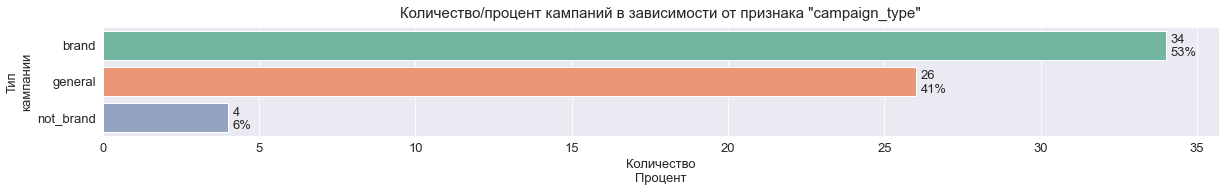

In [11]:
category_count('campaign_type', 'Тип\nкампании', (20, 2))

Добавим столбец `rating_type` с категориями:
- `1` - позиция ближе к 1
- `3` - позиция ближе к 3

In [12]:
def rating_type(rating):
    if rating<=1.5:
        return 1
    return 3    

In [13]:
df['rating_type'] = df['rating'].apply(rating_type)

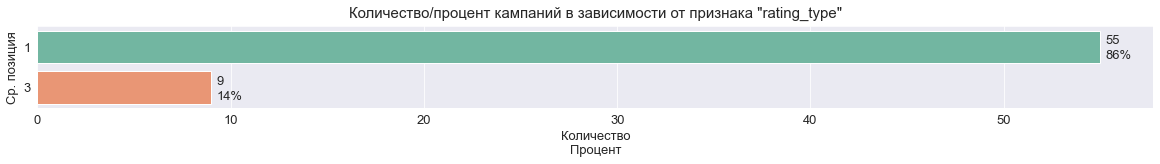

In [14]:
category_count('rating_type', 'Ср. позиция', (20, 1.5))

### Поиск дубликатов по рекламным кампаниям

Проверим, повторялись ли рекламные кампании в датасете в течение каждого месяца.

Количество объектов в датасете по месяцам:

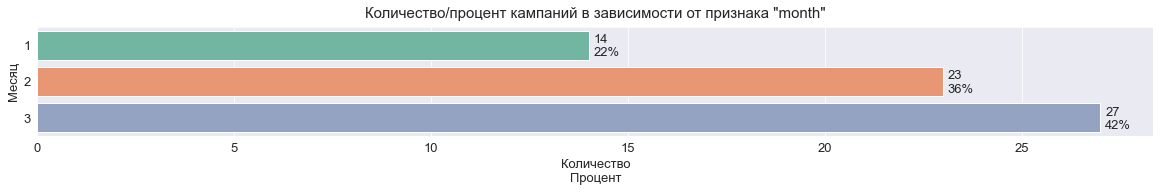

In [15]:
category_count('month', 'Месяц', (20, 2))

- месяцев в отчетном периоде три - январь, февраль, март
- количество кампаний от месяца к меcяцу возрастает

In [16]:
def duplicated_campaign (df: pd.DataFrame):  
    print(color.BOLD+color.UNDERLINE+'Количество явных дубликатов в наименованиях рекламных кампаний:'+color.END)
    print(df['campaign'].duplicated().sum())
    print('\n'+color.BOLD+color.UNDERLINE+'Количество явных дубликатов в номерах рекламных кампаний:'+color.END)
    print(df['campaign_number'].duplicated().sum())
    print('\n'+color.BOLD+color.UNDERLINE+'Количество явных дубликатов в наименованиях и номерах кампаний:'+color.END)
    print(df[['campaign','campaign_number']].duplicated().sum())

In [17]:
duplicated_campaign (df[df['month']==1])

Количество явных дубликатов в наименованиях рекламных кампаний:
1

Количество явных дубликатов в номерах рекламных кампаний:
0

Количество явных дубликатов в наименованиях и номерах кампаний:
0


In [18]:
duplicated_campaign (df[df['month']==2])

Количество явных дубликатов в наименованиях рекламных кампаний:
0

Количество явных дубликатов в номерах рекламных кампаний:
0

Количество явных дубликатов в наименованиях и номерах кампаний:
0


In [19]:
duplicated_campaign (df[df['month']==3])

Количество явных дубликатов в наименованиях рекламных кампаний:
2

Количество явных дубликатов в номерах рекламных кампаний:
0

Количество явных дубликатов в наименованиях и номерах кампаний:
0


По согласованию с заказчиком - уникальные рекламные объявления индексируются номером. По месяцам дубликатов в номерах рекламных кампаний нет.

## Расчёты

### Создание сводных таблиц

Посмотрим сколько всего показов по типам кампаний.

In [20]:
df.groupby('campaign_type')['show_count'].sum()

campaign_type
brand         154448
general       336504
not_brand    2207520
Name: show_count, dtype: int64

#### Сводный датасет для всех типов кампаний

In [21]:
top = df.pivot_table (index=['month'], columns=['rating_type','campaign_type'], aggfunc={'show_count':'sum'})
top

show_count                                       
rating_type            1                  3                    
campaign_type      brand   general    brand  general  not_brand
month                                                          
1               27796.00   9006.00      NaN      NaN  997920.00
2               31913.00  22429.00 14227.00 15621.00 1209600.00
3               61065.00 289448.00 19447.00      NaN        NaN

In [22]:
top.columns = ['top_1_brand', 'top_1_general', 'top_3_brand', 'top_3_general', 'top_3_not_brand']

Получили сводный датасет для всех типов кампаний

In [23]:
top = top.T
top

month,1,2,3
top_1_brand,27796.00,31913.00,61065.00
top_1_general,9006.00,22429.00,289448.00
top_3_brand,NaN,14227.00,19447.00
top_3_general,NaN,15621.00,NaN
top_3_not_brand,997920.00,1209600.00,NaN


#### Датасет для ТОП-1

In [24]:
top_1 = top[top.index.str.contains('top_1')]
top_1

month,1,2,3
top_1_brand,27796.00,31913.00,61065.00
top_1_general,9006.00,22429.00,289448.00


#### Датасет для ТОП-3

In [25]:
top_3 = top[top.index.str.contains('top_3')]
top_3

month,1,2,3
top_3_brand,NaN,14227.00,19447.00
top_3_general,NaN,15621.00,NaN
top_3_not_brand,997920.00,1209600.00,NaN


#### Функция для расчёта процентов

Создадим функцию `df_percentage()` для расчёта процентов показов.

На входе функции:
- `data` - исходный датафрейм

На выходе функции:
- `data` - преобразованный датафрейм

In [26]:
def df_percentage(data: pd.DataFrame):    
    for i,p in zip(data.columns,
                   ['percentage_jan', 'percentage_feb', 'percentage_mar']):
        data[p] = data.loc[:, i]*100/data.loc[:, i].sum()
    data = data.drop([1, 2, 3], axis=1)
    data['percentage_sum'] = data[['percentage_jan', 'percentage_feb', 'percentage_mar']].sum(axis=1, min_count=0)
    data = data.sort_values(by='percentage_sum', ascending=False).drop('percentage_sum', axis=1).fillna(0)
    return data

#### Проценты для всех типов кампаний

In [27]:
top = df_percentage(top)
top

month,percentage_jan,percentage_feb,percentage_mar
top_3_not_brand,96.44,93.49,0.00
top_1_general,0.87,1.73,78.24
top_1_brand,2.69,2.47,16.51
top_3_brand,0.00,1.10,5.26
top_3_general,0.00,1.21,0.00


#### Проценты для ТОП-1

In [28]:
top_1 = df_percentage(top_1)
top_1

month,percentage_jan,percentage_feb,percentage_mar
top_1_brand,75.53,58.73,17.42
top_1_general,24.47,41.27,82.58


#### Проценты для ТОП-3

In [29]:
top_3 = df_percentage(top_3)
top_3

month,percentage_jan,percentage_feb,percentage_mar
top_3_not_brand,100.00,97.59,0.00
top_3_brand,0.00,1.15,100.00
top_3_general,0.00,1.26,0.00


## Визуализация

### Функция создания тепловых карт  % показов

Создадим функцию `heat_percentage()`.

Функция выполняет:
- визуализацию результатов в виде тепловой карты
- эскпорт графики в `jpeg` формате

На входе функции:
- `df` - датасет
- `title` - наименование графика
- `y_title` - смещение наименования графика по оси y
- `width` - ширина графика
- `height` - высота графика

На выходе функции:
- тепловая карта для оценки динамики изменения процента показов по месяцам

In [30]:
def heat_percentage (df:pd.DataFrame, title: str, y_title: float, width: float, height: float):    
    fig = px.imshow(df,
                    text_auto='.1f',
                    aspect="auto")
    
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    
    fig.update_layout(title={'text': f'{title}.<br>Тепловая карта % показов',
                             'y':y_title,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},                      
                      width=width,
                      height=height,                      
                      coloraxis = dict(colorscale='YlGn', cmax=100, cmin=0),                      
                      coloraxis_colorbar=dict(title = dict(text='% показов', side='right'),
                                              x=1.0,
                                              len=1.05,
                                              thickness=15)
                      )
    
    fig.show('png')
    fig.write_image(f'M:/datasets/presentation/images/{title} хитмэп.jpeg', scale=5)

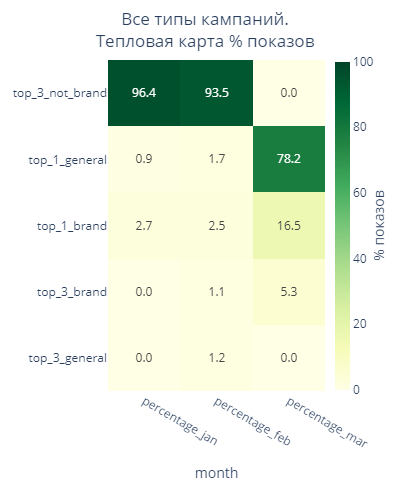

In [31]:
heat_percentage(top,
                'Все типы кампаний',
                y_title = 0.95,
                width = 410,
                height = 490)

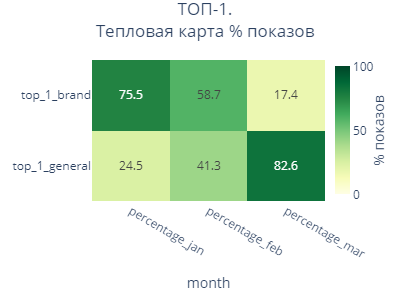

In [32]:
heat_percentage(top_1,
                'ТОП-1',
                y_title = 0.95,
                width = 410,
                height = 300)

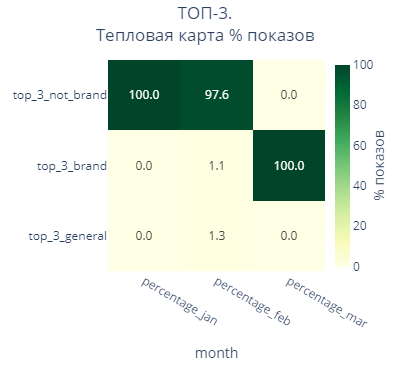

In [33]:
heat_percentage(top_3,
                'ТОП-3',
                y_title = 0.95,
                width = 410,
                height = 370)

In [34]:
def stack_percentage (df:pd.DataFrame, title: str, y_title: float, width: float, height: float):   
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        y=df.index, orientation='h', width = 0.9,
        x=df['percentage_jan'],
        name='янв',
        marker_color='deepskyblue',
    ))
    fig.add_trace(go.Bar(
        y=df.index, orientation='h', width = 0.9,
        x=df['percentage_feb'],
        name='фев',
        marker_color='limegreen',
    ))
    fig.add_trace(go.Bar(
        y=df.index, orientation='h', width = 0.9,
        x=df['percentage_mar'],
        name='мар',
        marker_color='gold',
    ))
    fig.update_traces(marker={'opacity': 0.5})    
    fig.update_xaxes(showticklabels=False, showgrid=False)
    
    fig.update_layout(barmode='stack',
                      title={'text': f'{title}.<br>Стековая диаграмма % показов',
                             'y': y_title,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      
                      width = width,
                      height = height,
                      autosize = False,
                      plot_bgcolor='rgba(0,0,0,0)',
                      legend=dict(title='Месяц', x=0.25, y=-.01, orientation = 'h', traceorder = 'normal'))
    
    fig.update_layout(hovermode="y unified")
    
    fig.show('png')
    fig.write_image(f'M:/datasets/presentation/images/{title} стековая диаграмма.jpeg', scale=5)

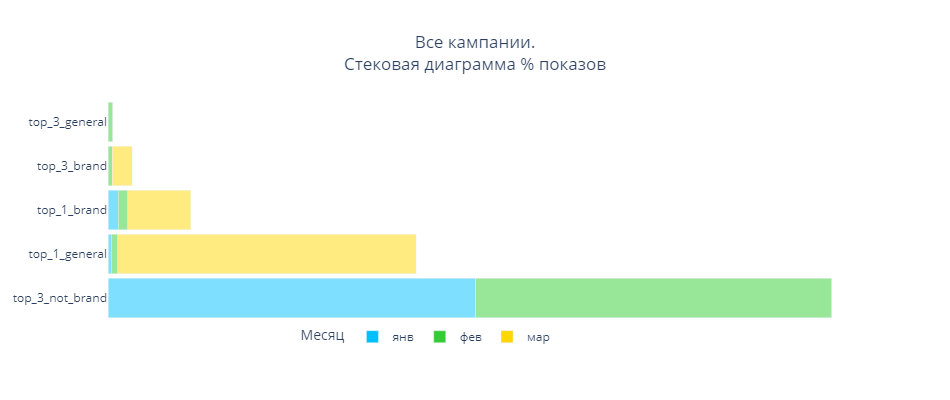

In [35]:
stack_percentage (top, 'Все кампании', y_title=0.88, width=950, height=400)

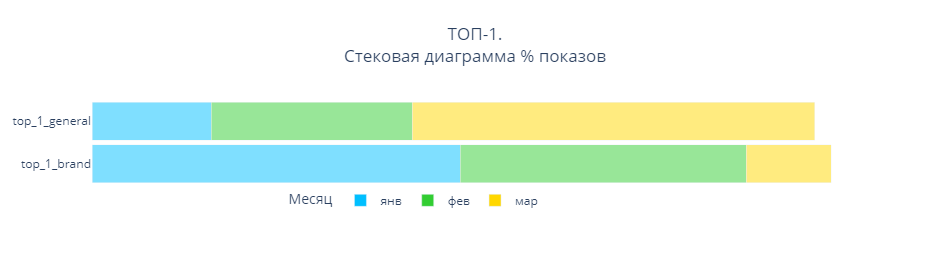

In [36]:
stack_percentage (top_1, 'ТОП-1', y_title=0.85, width=950, height=265)

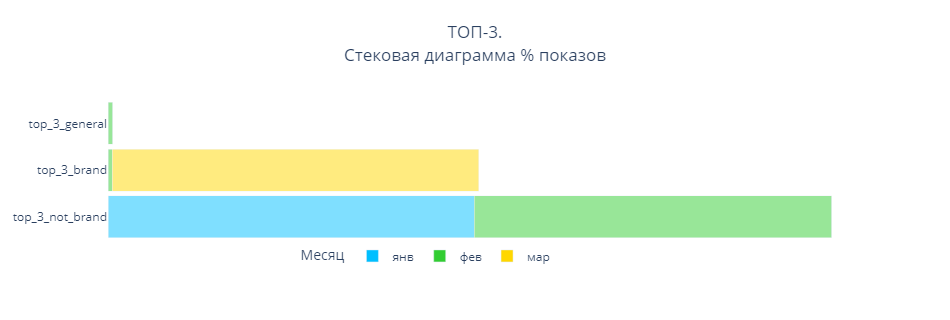

In [37]:
stack_percentage (top_3, 'ТОП-3', y_title=0.88, width=950, height=320)

## Выгрузка данных

- Для удобства работы заказчика с полученными данными выгрузим результаты в формате `xlsx`

In [38]:
writer = pd.ExcelWriter('M:/datasets/presentation/presentation_task_3.xlsx', engine='xlsxwriter')

top.to_excel(writer, sheet_name='top')
top_1.to_excel(writer, sheet_name='top_1')
top_3.to_excel(writer, sheet_name='top_3')

writer.save()

## Выводы

Результаты маркетологов в части повышения видимости рекламы.

ТОП-1 :
- неброндовые кампании в ТОП-1 не входят
- у брендовых кампаний максимальный суммарный процент немного выше, чем у общих
- процент показов общих рекламных кампаний от месяца к месяцу растет, у брендовых падает

ТОП-3:
- суммарный процент небрендовых кампаний значительно выше остальных, однако, в марте небрендовых кампаний не было
- процент общих рекламных кампаний в ТОП-3 минимальный
- в марте проходили только брендовые рекламные кампании в этой категории

Все кампании:
- суммарный процент небрендовых кампаний значительно выше остальных, однако, в марте небрендовых кампаний не было
- процентом рекламных общих кампаний ТОП-3 в категории "все кампании" можно пренебречь
- общие рекламные кампании категории ТОП-1 лидируют по проценту показов в марте

На основании проделанной работы заказчику предоставлен слайд для отчетной презентации.